# Consumer Sentiment Analysis Using Pretrained Transformer-Based Models - Vader, RoBERTa and DistilBERT

## Importing required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
nltk.download('stopwords')

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Read in data
df = pd.read_csv('amazon_review_dataset.csv')
df = df.head(10000)
print(df.shape)

(10000, 10)


In [4]:
df.head()

Id   ProductId          UserId                ProfileName  \
0  148492  B003JA5KLM  A1TITOWKMCRDL2                      Jesto   
1  390216  B000GZUFKE  A1QGO6SNT6X1VU                iLoveWinnie   
2   31694  B005GX6G9K  A24V317F6FQOFH           Tara S. Scherner   
3   33252  B001EQ54M8   ARB94UKTX6OVK  Go Bears 1986 "Hard Knox"   
4  276055  B000FBMFDO  A2MUTRCN4YCJHL                       Nate   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      1  1348790400   
1                     0                       0      2  1321660800   
2                     0                       1      1  1348185600   
3                    23                      35      1  1261699200   
4                     0                       0      3  1345248000   

                                             Summary  \
0                                Weak, boring coffee   
1                               Neither hot nor sour   
2  If Your Kids are Stupid Enough to Think Water ...   
3                                only 3/4 pound bags   
4  Mixed feeling, effective but not as easy as pe...   

                                                Text  
0  Got a sample of this today and was excited to ...  
1  I enjoy spicy food a lot so I bought a cup of ...  
2  Each of the different Wat-aah! varieties have ...  
3  At the Starbucks online store, this coffee is ...  
4  I really don't like how everyone makes it seem...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             9999 non-null   object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 9998 non-null   object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


### No Missing Values

In [6]:
df['Score'].value_counts()

Score
2    2031
3    2024
1    1992
4    1983
5    1970
Name: count, dtype: int64

# **Basic EDA of the Review Text**

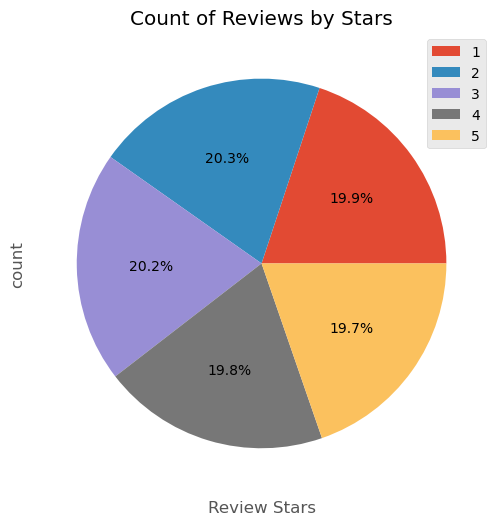

In [56]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='pie',
          title='Count of Reviews by Stars',
          figsize=(10, 6), autopct='%1.1f%%', labels=None)
ax.legend(labels=['1','2','3','4','5'])
ax.set_xlabel('Review Stars')
plt.show()

## Cleaning the data

In [8]:
def clean(review):
    
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review

In [9]:
df['Text'] = df['Text'].apply(clean)
df.head(10)

Id   ProductId          UserId                ProfileName  \
0  148492  B003JA5KLM  A1TITOWKMCRDL2                      Jesto   
1  390216  B000GZUFKE  A1QGO6SNT6X1VU                iLoveWinnie   
2   31694  B005GX6G9K  A24V317F6FQOFH           Tara S. Scherner   
3   33252  B001EQ54M8   ARB94UKTX6OVK  Go Bears 1986 "Hard Knox"   
4  276055  B000FBMFDO  A2MUTRCN4YCJHL                       Nate   
5  116225  B001IZJPCK  A2GQG67E7P93WW           Eleanor G Kelley   
6  142503  B000WFLT44  A3ROKP9GHLF5V3                Adrian Meli   
7  259597  B001EPQPYA  A31LG76L3GVAYM   Tammy S. Robbins "Tammy"   
8   57144  B003ULVY92  A1VF48M5794CSY                  Uvaturtle   
9    7648  B000TRFGGM  A1NBR725PHCZ8Q                    charlie   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      1  1348790400   
1                     0                       0      2  1321660800   
2                     0                       1      1  1348185600   
3                    23                      35      1  1261699200   
4                     0                       0      3  1345248000   
5                     0                       0      5  1339804800   
6                     0                       0      5  1300838400   
7                     1                       1      1  1262563200   
8                     3                       5      1  1316217600   
9                     0                       0      2  1311465600   

                                             Summary  \
0                                Weak, boring coffee   
1                               Neither hot nor sour   
2  If Your Kids are Stupid Enough to Think Water ...   
3                                only 3/4 pound bags   
4  Mixed feeling, effective but not as easy as pe...   
5                                            yummmmm   
6                 Great dog food, not full of filler   
7                           3 of the bags broke!!!!!   
8                                  Expired crackers!   
9                                    brown and small   

                                                Text  
0  got sample today excited try fail brewing smel...  
1  enjoy spicy food lot bought cup fiestabr turne...  
2  different wat-aah varieties themes picked powe...  
3  starbucks online store coffee 1095lb approx 68...  
4  really dont like everyone makes seem easy use ...  
5  hard find anywhere nowadays like chewbr br rem...  
6  feeding dog natures recipe since puppy skin pr...  
7  buy item 3 bags broke cannot return first time...  
8  excited find amazon trying recent flight airpl...  
9  received pant faster expected brown considerab...

In [10]:
df['Text'][0]

'got sample today excited try fail brewing smelled great came dark first quickly changed light watery colour boring taste like dark coffee daily drink timothys midnight magic extra bold wife likes timothys morning blend prefers light roast even didnt like coffee said tastes like warm milk'

## Splitting the text data

In [11]:
def corpus(text):
    text_list = text.split()
    return text_list

In [12]:
df['review_lists'] = df['Text'].apply(corpus)
df.head(10)

Id   ProductId          UserId                ProfileName  \
0  148492  B003JA5KLM  A1TITOWKMCRDL2                      Jesto   
1  390216  B000GZUFKE  A1QGO6SNT6X1VU                iLoveWinnie   
2   31694  B005GX6G9K  A24V317F6FQOFH           Tara S. Scherner   
3   33252  B001EQ54M8   ARB94UKTX6OVK  Go Bears 1986 "Hard Knox"   
4  276055  B000FBMFDO  A2MUTRCN4YCJHL                       Nate   
5  116225  B001IZJPCK  A2GQG67E7P93WW           Eleanor G Kelley   
6  142503  B000WFLT44  A3ROKP9GHLF5V3                Adrian Meli   
7  259597  B001EPQPYA  A31LG76L3GVAYM   Tammy S. Robbins "Tammy"   
8   57144  B003ULVY92  A1VF48M5794CSY                  Uvaturtle   
9    7648  B000TRFGGM  A1NBR725PHCZ8Q                    charlie   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      1  1348790400   
1                     0                       0      2  1321660800   
2                     0                       1      1  1348185600   
3                    23                      35      1  1261699200   
4                     0                       0      3  1345248000   
5                     0                       0      5  1339804800   
6                     0                       0      5  1300838400   
7                     1                       1      1  1262563200   
8                     3                       5      1  1316217600   
9                     0                       0      2  1311465600   

                                             Summary  \
0                                Weak, boring coffee   
1                               Neither hot nor sour   
2  If Your Kids are Stupid Enough to Think Water ...   
3                                only 3/4 pound bags   
4  Mixed feeling, effective but not as easy as pe...   
5                                            yummmmm   
6                 Great dog food, not full of filler   
7                           3 of the bags broke!!!!!   
8                                  Expired crackers!   
9                                    brown and small   

                                                Text  \
0  got sample today excited try fail brewing smel...   
1  enjoy spicy food lot bought cup fiestabr turne...   
2  different wat-aah varieties themes picked powe...   
3  starbucks online store coffee 1095lb approx 68...   
4  really dont like everyone makes seem easy use ...   
5  hard find anywhere nowadays like chewbr br rem...   
6  feeding dog natures recipe since puppy skin pr...   
7  buy item 3 bags broke cannot return first time...   
8  excited find amazon trying recent flight airpl...   
9  received pant faster expected brown considerab...   

                                        review_lists  
0  [got, sample, today, excited, try, fail, brewi...  
1  [enjoy, spicy, food, lot, bought, cup, fiestab...  
2  [different, wat-aah, varieties, themes, picked...  
3  [starbucks, online, store, coffee, 1095lb, app...  
4  [really, dont, like, everyone, makes, seem, ea...  
5  [hard, find, anywhere, nowadays, like, chewbr,...  
6  [feeding, dog, natures, recipe, since, puppy, ...  
7  [buy, item, 3, bags, broke, cannot, return, fi...  
8  [excited, find, amazon, trying, recent, flight...  
9  [received, pant, faster, expected, brown, cons...

In [13]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['review_lists'][i]
len(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 167106.41it/s]


463985

## Most frequently occurring words

In [14]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('br', 5614),
 ('like', 5378),
 ('taste', 3704),
 ('good', 3666),
 ('coffee', 3454),
 ('one', 3266),
 ('product', 3097),
 ('would', 3074),
 ('flavor', 2913),
 ('tea', 2302)]

In [15]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

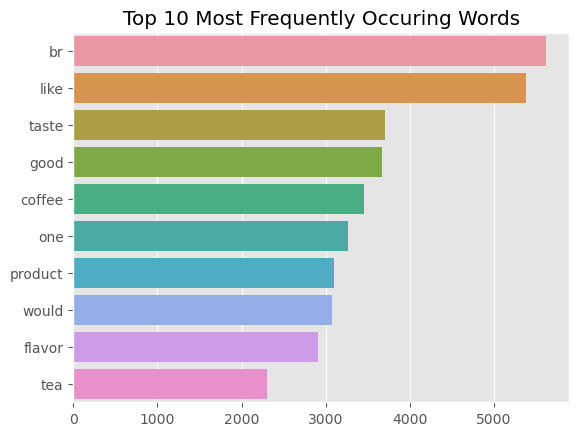

In [16]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

In [18]:
example = df['Text'][50]
print(example)

prosbr br -easy one clean upbr -bpa freebr -doesnt take lot spacebr br consbr br -makes small batches fit half sweet potato barely two applesbr -takes longer make bulk baby food cant blend steamingbr -steaming times way long let unit cool 5 mins touch else get burned


# **Basic NLTK and pre-processing**

In [19]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\salon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\salon\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\salon\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\salon\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [20]:
# Breaking sentence in tokens
tokens = nltk.word_tokenize(example)

print(f' Sentence: {example}')
print(f'   Tokens: {tokens}')

 Sentence: prosbr br -easy one clean upbr -bpa freebr -doesnt take lot spacebr br consbr br -makes small batches fit half sweet potato barely two applesbr -takes longer make bulk baby food cant blend steamingbr -steaming times way long let unit cool 5 mins touch else get burned
   Tokens: ['prosbr', 'br', '-easy', 'one', 'clean', 'upbr', '-bpa', 'freebr', '-doesnt', 'take', 'lot', 'spacebr', 'br', 'consbr', 'br', '-makes', 'small', 'batches', 'fit', 'half', 'sweet', 'potato', 'barely', 'two', 'applesbr', '-takes', 'longer', 'make', 'bulk', 'baby', 'food', 'cant', 'blend', 'steamingbr', '-steaming', 'times', 'way', 'long', 'let', 'unit', 'cool', '5', 'mins', 'touch', 'else', 'get', 'burned']


In [21]:
# Part of speech tagging of each of the tokens
tagged = nltk.pos_tag(tokens)
tagged

[('prosbr', 'NN'),
 ('br', 'NN'),
 ('-easy', 'NNP'),
 ('one', 'CD'),
 ('clean', 'NN'),
 ('upbr', 'JJ'),
 ('-bpa', 'NNP'),
 ('freebr', 'NN'),
 ('-doesnt', 'NNP'),
 ('take', 'VB'),
 ('lot', 'NN'),
 ('spacebr', 'NNS'),
 ('br', 'VBP'),
 ('consbr', 'JJ'),
 ('br', 'NN'),
 ('-makes', 'NNS'),
 ('small', 'JJ'),
 ('batches', 'NNS'),
 ('fit', 'JJ'),
 ('half', 'JJ'),
 ('sweet', 'JJ'),
 ('potato', 'NN'),
 ('barely', 'RB'),
 ('two', 'CD'),
 ('applesbr', 'JJ'),
 ('-takes', 'NNS'),
 ('longer', 'RB'),
 ('make', 'VBP'),
 ('bulk', 'JJ'),
 ('baby', 'NN'),
 ('food', 'NN'),
 ('cant', 'JJ'),
 ('blend', 'NN'),
 ('steamingbr', 'NN'),
 ('-steaming', 'VBG'),
 ('times', 'NNS'),
 ('way', 'NN'),
 ('long', 'JJ'),
 ('let', 'NN'),
 ('unit', 'NN'),
 ('cool', 'JJ'),
 ('5', 'CD'),
 ('mins', 'NNS'),
 ('touch', 'JJ'),
 ('else', 'RB'),
 ('get', 'VBP'),
 ('burned', 'VBN')]

In [22]:
# Named entity chunking of sequence of words
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  prosbr/NN
  br/NN
  -easy/NNP
  one/CD
  clean/NN
  upbr/JJ
  -bpa/NNP
  freebr/NN
  -doesnt/NNP
  take/VB
  lot/NN
  spacebr/NNS
  br/VBP
  consbr/JJ
  br/NN
  -makes/NNS
  small/JJ
  batches/NNS
  fit/JJ
  half/JJ
  sweet/JJ
  potato/NN
  barely/RB
  two/CD
  applesbr/JJ
  -takes/NNS
  longer/RB
  make/VBP
  bulk/JJ
  baby/NN
  food/NN
  cant/JJ
  blend/NN
  steamingbr/NN
  -steaming/VBG
  times/NNS
  way/NN
  long/JJ
  let/NN
  unit/NN
  cool/JJ
  5/CD
  mins/NNS
  touch/JJ
  else/RB
  get/VBP
  burned/VBN)


# **1. VADER Seniment Scoring**

We used NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
1. Stop words are removed
1. each word is scored and combined to a total score.

In [23]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [24]:
# Positive Sentiment Example
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [25]:
# Negative Sentiment Example
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [26]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [28]:
# Now we have sentiment score and metadata
vaders.head()

Id    neg    neu    pos  compound   ProductId          UserId  \
0  148492  0.092  0.571  0.338    0.9260  B003JA5KLM  A1TITOWKMCRDL2   
1  390216  0.000  0.747  0.253    0.7269  B000GZUFKE  A1QGO6SNT6X1VU   
2   31694  0.120  0.748  0.131    0.3489  B005GX6G9K  A24V317F6FQOFH   
3   33252  0.050  0.751  0.199    0.8074  B001EQ54M8   ARB94UKTX6OVK   
4  276055  0.125  0.677  0.198    0.8755  B000FBMFDO  A2MUTRCN4YCJHL   

                 ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                      Jesto                     0                       0   
1                iLoveWinnie                     0                       0   
2           Tara S. Scherner                     0                       1   
3  Go Bears 1986 "Hard Knox"                    23                      35   
4                       Nate                     0                       0   

   Score        Time                                            Summary  \
0      1  1348790400                                Weak, boring coffee   
1      2  1321660800                               Neither hot nor sour   
2      1  1348185600  If Your Kids are Stupid Enough to Think Water ...   
3      1  1261699200                                only 3/4 pound bags   
4      3  1345248000  Mixed feeling, effective but not as easy as pe...   

                                                Text  \
0  got sample today excited try fail brewing smel...   
1  enjoy spicy food lot bought cup fiestabr turne...   
2  different wat-aah varieties themes picked powe...   
3  starbucks online store coffee 1095lb approx 68...   
4  really dont like everyone makes seem easy use ...   

                                        review_lists  
0  [got, sample, today, excited, try, fail, brewi...  
1  [enjoy, spicy, food, lot, bought, cup, fiestab...  
2  [different, wat-aah, varieties, themes, picked...  
3  [starbucks, online, store, coffee, 1095lb, app...  
4  [really, dont, like, everyone, makes, seem, ea...

# **Plot VADER results**

In [29]:
df['reviews_score'] = df['Text'].apply(lambda review: sia.polarity_scores(review))

df.head()

Id   ProductId          UserId                ProfileName  \
0  148492  B003JA5KLM  A1TITOWKMCRDL2                      Jesto   
1  390216  B000GZUFKE  A1QGO6SNT6X1VU                iLoveWinnie   
2   31694  B005GX6G9K  A24V317F6FQOFH           Tara S. Scherner   
3   33252  B001EQ54M8   ARB94UKTX6OVK  Go Bears 1986 "Hard Knox"   
4  276055  B000FBMFDO  A2MUTRCN4YCJHL                       Nate   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      1  1348790400   
1                     0                       0      2  1321660800   
2                     0                       1      1  1348185600   
3                    23                      35      1  1261699200   
4                     0                       0      3  1345248000   

                                             Summary  \
0                                Weak, boring coffee   
1                               Neither hot nor sour   
2  If Your Kids are Stupid Enough to Think Water ...   
3                                only 3/4 pound bags   
4  Mixed feeling, effective but not as easy as pe...   

                                                Text  \
0  got sample today excited try fail brewing smel...   
1  enjoy spicy food lot bought cup fiestabr turne...   
2  different wat-aah varieties themes picked powe...   
3  starbucks online store coffee 1095lb approx 68...   
4  really dont like everyone makes seem easy use ...   

                                        review_lists  \
0  [got, sample, today, excited, try, fail, brewi...   
1  [enjoy, spicy, food, lot, bought, cup, fiestab...   
2  [different, wat-aah, varieties, themes, picked...   
3  [starbucks, online, store, coffee, 1095lb, app...   
4  [really, dont, like, everyone, makes, seem, ea...   

                                       reviews_score  
0  {'neg': 0.092, 'neu': 0.571, 'pos': 0.338, 'co...  
1  {'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'comp...  
2  {'neg': 0.12, 'neu': 0.748, 'pos': 0.131, 'com...  
3  {'neg': 0.05, 'neu': 0.751, 'pos': 0.199, 'com...  
4  {'neg': 0.125, 'neu': 0.677, 'pos': 0.198, 'co...

In [30]:
df['compound']  = df['reviews_score'].apply(lambda score_dict: score_dict['compound'])

df.head()

Id   ProductId          UserId                ProfileName  \
0  148492  B003JA5KLM  A1TITOWKMCRDL2                      Jesto   
1  390216  B000GZUFKE  A1QGO6SNT6X1VU                iLoveWinnie   
2   31694  B005GX6G9K  A24V317F6FQOFH           Tara S. Scherner   
3   33252  B001EQ54M8   ARB94UKTX6OVK  Go Bears 1986 "Hard Knox"   
4  276055  B000FBMFDO  A2MUTRCN4YCJHL                       Nate   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      1  1348790400   
1                     0                       0      2  1321660800   
2                     0                       1      1  1348185600   
3                    23                      35      1  1261699200   
4                     0                       0      3  1345248000   

                                             Summary  \
0                                Weak, boring coffee   
1                               Neither hot nor sour   
2  If Your Kids are Stupid Enough to Think Water ...   
3                                only 3/4 pound bags   
4  Mixed feeling, effective but not as easy as pe...   

                                                Text  \
0  got sample today excited try fail brewing smel...   
1  enjoy spicy food lot bought cup fiestabr turne...   
2  different wat-aah varieties themes picked powe...   
3  starbucks online store coffee 1095lb approx 68...   
4  really dont like everyone makes seem easy use ...   

                                        review_lists  \
0  [got, sample, today, excited, try, fail, brewi...   
1  [enjoy, spicy, food, lot, bought, cup, fiestab...   
2  [different, wat-aah, varieties, themes, picked...   
3  [starbucks, online, store, coffee, 1095lb, app...   
4  [really, dont, like, everyone, makes, seem, ea...   

                                       reviews_score  compound  
0  {'neg': 0.092, 'neu': 0.571, 'pos': 0.338, 'co...    0.9260  
1  {'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'comp...    0.7269  
2  {'neg': 0.12, 'neu': 0.748, 'pos': 0.131, 'com...    0.3489  
3  {'neg': 0.05, 'neu': 0.751, 'pos': 0.199, 'com...    0.8074  
4  {'neg': 0.125, 'neu': 0.677, 'pos': 0.198, 'co...    0.8755

In [31]:
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

df.head()

Id   ProductId          UserId                ProfileName  \
0  148492  B003JA5KLM  A1TITOWKMCRDL2                      Jesto   
1  390216  B000GZUFKE  A1QGO6SNT6X1VU                iLoveWinnie   
2   31694  B005GX6G9K  A24V317F6FQOFH           Tara S. Scherner   
3   33252  B001EQ54M8   ARB94UKTX6OVK  Go Bears 1986 "Hard Knox"   
4  276055  B000FBMFDO  A2MUTRCN4YCJHL                       Nate   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      1  1348790400   
1                     0                       0      2  1321660800   
2                     0                       1      1  1348185600   
3                    23                      35      1  1261699200   
4                     0                       0      3  1345248000   

                                             Summary  \
0                                Weak, boring coffee   
1                               Neither hot nor sour   
2  If Your Kids are Stupid Enough to Think Water ...   
3                                only 3/4 pound bags   
4  Mixed feeling, effective but not as easy as pe...   

                                                Text  \
0  got sample today excited try fail brewing smel...   
1  enjoy spicy food lot bought cup fiestabr turne...   
2  different wat-aah varieties themes picked powe...   
3  starbucks online store coffee 1095lb approx 68...   
4  really dont like everyone makes seem easy use ...   

                                        review_lists  \
0  [got, sample, today, excited, try, fail, brewi...   
1  [enjoy, spicy, food, lot, bought, cup, fiestab...   
2  [different, wat-aah, varieties, themes, picked...   
3  [starbucks, online, store, coffee, 1095lb, app...   
4  [really, dont, like, everyone, makes, seem, ea...   

                                       reviews_score  compound comp_score  
0  {'neg': 0.092, 'neu': 0.571, 'pos': 0.338, 'co...    0.9260        pos  
1  {'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'comp...    0.7269        pos  
2  {'neg': 0.12, 'neu': 0.748, 'pos': 0.131, 'com...    0.3489        pos  
3  {'neg': 0.05, 'neu': 0.751, 'pos': 0.199, 'com...    0.8074        pos  
4  {'neg': 0.125, 'neu': 0.677, 'pos': 0.198, 'co...    0.8755        pos

In [32]:
selected_columns = df.filter(items=['Score','Text','compound','comp_score'])
print(selected_columns)

      Score                                               Text  compound  \
0         1  got sample today excited try fail brewing smel...    0.9260   
1         2  enjoy spicy food lot bought cup fiestabr turne...    0.7269   
2         1  different wat-aah varieties themes picked powe...    0.3489   
3         1  starbucks online store coffee 1095lb approx 68...    0.8074   
4         3  really dont like everyone makes seem easy use ...    0.8755   
...     ...                                                ...       ...   
9995      2  weve tried several brands soy butter daughter ...    0.7506   
9996      5  first discovered ahmad earl grey tea 25 years ...    0.8539   
9997      4  illy issimo coffee drink - first smells wonder...    0.8489   
9998      3  hello purchased product based reviews tried 2 ...    0.8360   
9999      3  good product buy larger bags better value exce...    0.8979   

     comp_score  
0           pos  
1           pos  
2           pos  
3           pos

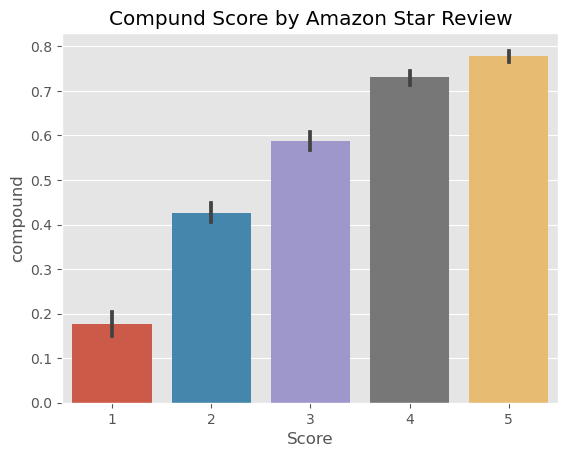

In [33]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

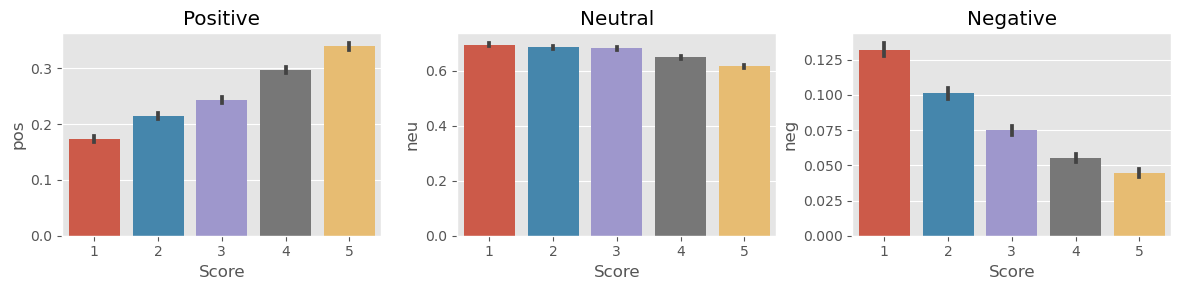

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# **Using Roberta Pretrained Model**


*   Use a model trained of a large corpus of data.
*   Transformer model accounts for the words but also the context related to other words.

In [35]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [36]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

C:\Users\salon\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [37]:
# VADER results on example
print(example)
sia.polarity_scores(example)

prosbr br -easy one clean upbr -bpa freebr -doesnt take lot spacebr br consbr br -makes small batches fit half sweet potato barely two applesbr -takes longer make bulk baby food cant blend steamingbr -steaming times way long let unit cool 5 mins touch else get burned


{'neg': 0.0, 'neu': 0.754, 'pos': 0.246, 'compound': 0.9081}

In [57]:
# Run for Roberta Model
encoded_text = tokenizer(example, padding=True, truncation=True, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.31388143, 'roberta_neu': 0.5363571, 'roberta_pos': 0.14976145}


In [39]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [40]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Broke for id 137041
Broke for id 47938
Broke for id 333469
Broke for id 23088
Broke for id 105815
Broke for id 118388
Broke for id 136892
Broke for id 282352
Broke for id 235723
Broke for id 207558


In [41]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [42]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text', 'review_lists', 'reviews_score',
       'compound', 'comp_score'],
      dtype='object')

# **Compare Scores between Vader Model and Roberta's pretained Models**

C:\Users\salon\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


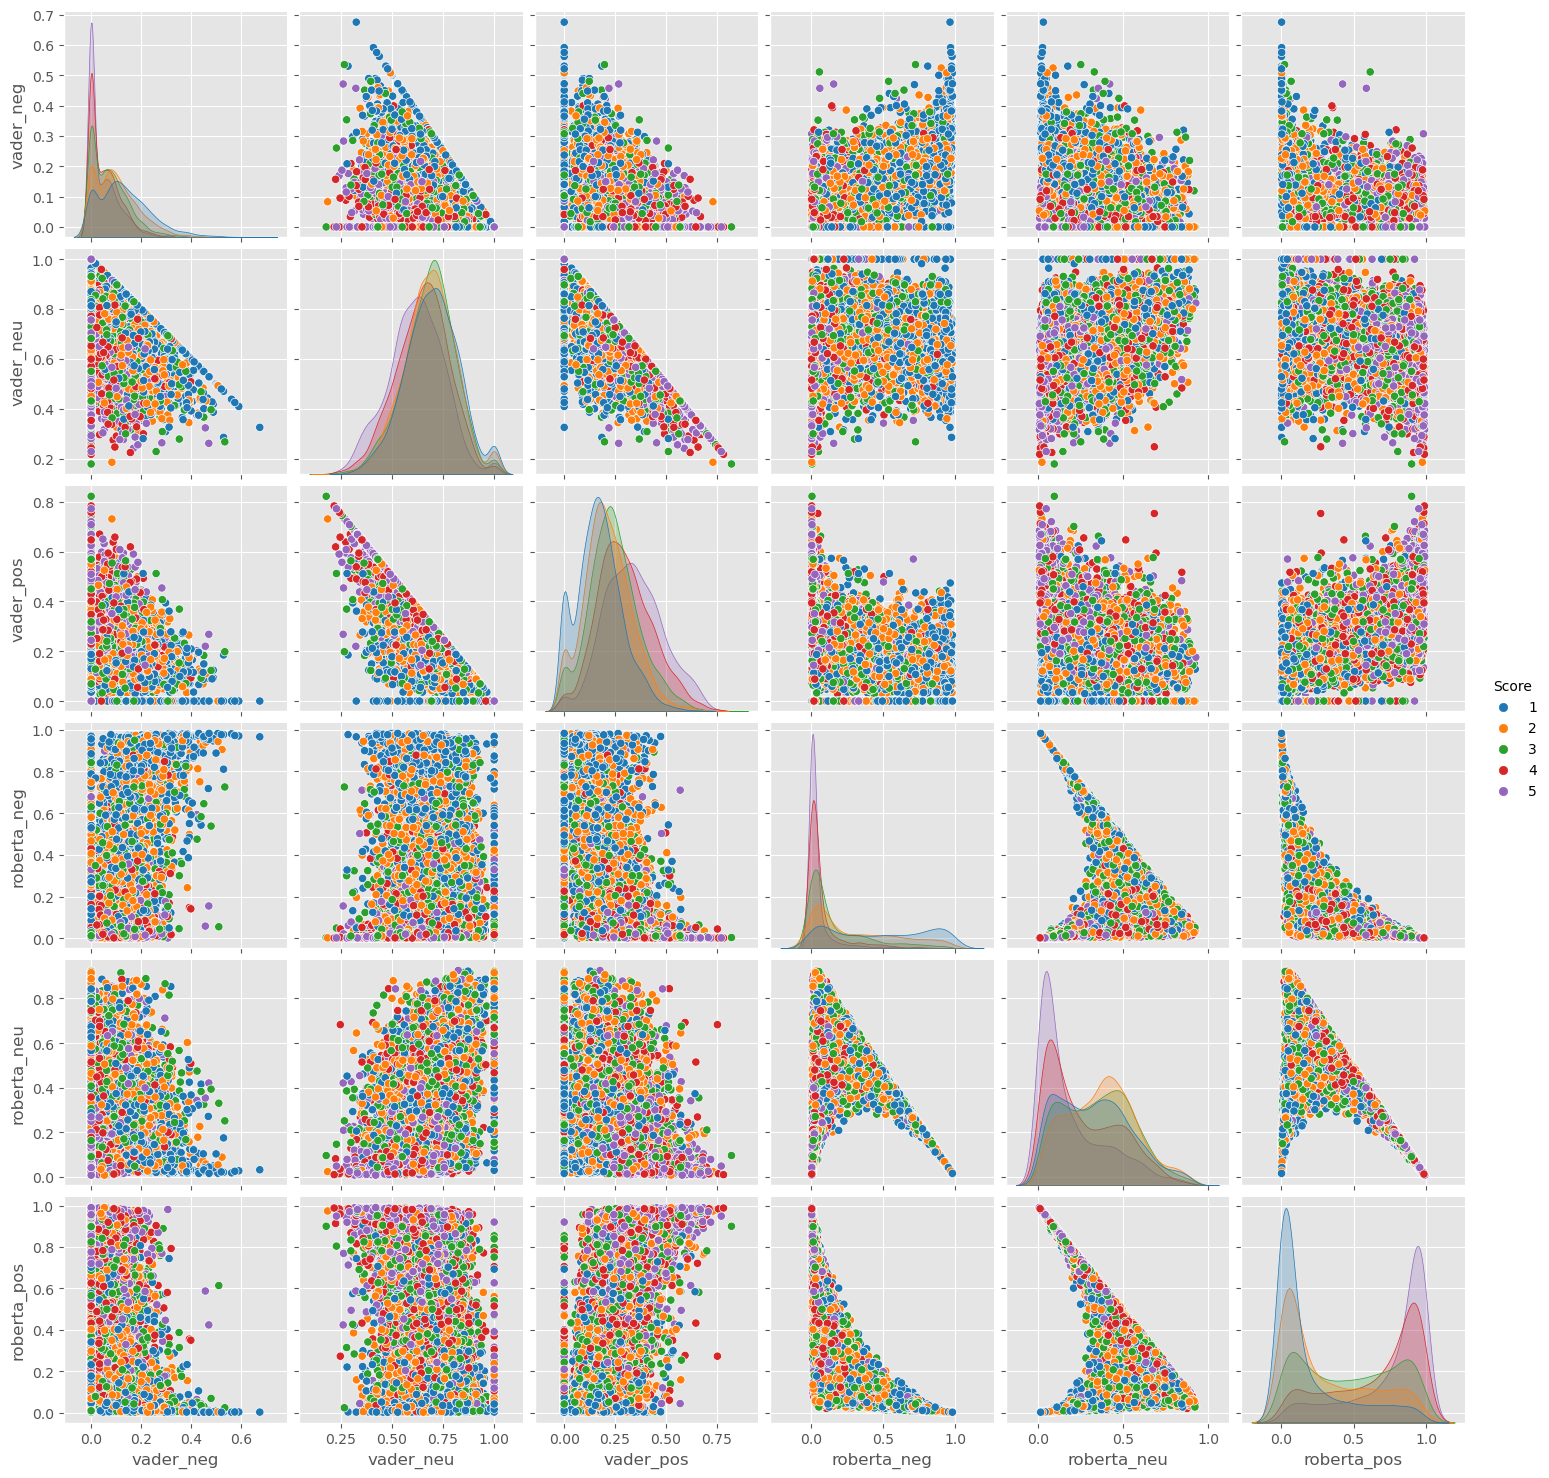

In [43]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# **Review Examples:**
Positive 1-Star and Negative 5-Star Reviews

In [44]:
results_df

Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0     148492      0.092      0.571      0.338          0.9260     0.027297   
1     390216      0.000      0.747      0.253          0.7269     0.002449   
2      31694      0.120      0.748      0.131          0.3489     0.512921   
3      33252      0.050      0.751      0.199          0.8074     0.010811   
4     276055      0.125      0.677      0.198          0.8755     0.220144   
...      ...        ...        ...        ...             ...          ...   
9985  279490      0.054      0.781      0.165          0.7506     0.096350   
9986  119259      0.000      0.756      0.244          0.8539     0.005970   
9987   63581      0.091      0.515      0.394          0.8489     0.002445   
9988  161572      0.063      0.697      0.240          0.8360     0.073467   
9989  333924      0.000      0.431      0.569          0.8979     0.012560   

      roberta_neu  roberta_pos   ProductId          UserId  ...  \
0        0.182699     0.790004  B003JA5KLM  A1TITOWKMCRDL2  ...   
1        0.027691     0.969860  B000GZUFKE  A1QGO6SNT6X1VU  ...   
2        0.431892     0.055187  B005GX6G9K  A24V317F6FQOFH  ...   
3        0.091838     0.897351  B001EQ54M8   ARB94UKTX6OVK  ...   
4        0.584661     0.195195  B000FBMFDO  A2MUTRCN4YCJHL  ...   
...           ...          ...         ...             ...  ...   
9985     0.505719     0.397932  B000GZSDPS  A31CXKAMPTZ0KV  ...   
9986     0.142511     0.851519  B001FA1LKC  A2XLHWP7IY2FUV  ...   
9987     0.013088     0.984467  B002IEZJMA   A79372WBA9IJM  ...   
9988     0.427430     0.499103  B000GPM9IK  A2U8MSSBRLOMHL  ...   
9989     0.163319     0.824121  B0032B0BD0   ALL51PH9IIA5X  ...   

     HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                       0                       0      1  1348790400   
1                       0                       0      2  1321660800   
2                       0                       1      1  1348185600   
3                      23                      35      1  1261699200   
4                       0                       0      3  1345248000   
...                   ...                     ...    ...         ...   
9985                    0                       0      2  1348963200   
9986                    0                       0      5  1294012800   
9987                    0                       1      4  1340755200   
9988                    0                       0      3  1350518400   
9989                    0                       0      3  1311552000   

                                                Summary  \
0                                   Weak, boring coffee   
1                                  Neither hot nor sour   
2     If Your Kids are Stupid Enough to Think Water ...   
3                                   only 3/4 pound bags   
4     Mixed feeling, effective but not as easy as pe...   
...                                                 ...   
9985      Lots of soy taste ; far inferior to Wowbutter   
9986                                 Best Earl Grey Tea   
9987            Overall quite tasty for a can of coffee   
9988                          good product, bad product   
9989  Garden of Eatin' Tortilla Chips, Blue, No Salt...   

                                                   Text  \
0     got sample today excited try fail brewing smel...   
1     enjoy spicy food lot bought cup fiestabr turne...   
2     different wat-aah varieties themes picked powe...   
3     starbucks online store coffee 1095lb approx 68...   
4     really dont like everyone makes seem easy use ...   
...                                                 ...   
9985  weve tried several brands soy butter daughter ...   
9986  first discovered ahmad earl grey tea 25 years ...   
9987  illy issimo coffee drink - first smells wonder...   
9988  hello purchased product based reviews tried 2 ...   
9989  good product buy larger bags better val

In [45]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'excited find read great reviews ordered 15 amazon work taste great large school popcorn maker however offered 348 local food warehouse wow amazon really making money one shop local buy overpriced wonder'

In [46]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'love vita cocos except one funny taste favorite'

In [47]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'dog destroyed nearly every toy given far dino bone kong two lastedi would recommend toy anyone dog heavy chewer'

In [62]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'tea great husband doesnt like tea loves like'

In [63]:
pip install --upgrade pip

In [64]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


# **3. Using distilbert-base-uncased Pretrained Model**

In [65]:
example = df['Text'][50]
print(example)

prosbr br -easy one clean upbr -bpa freebr -doesnt take lot spacebr br consbr br -makes small batches fit half sweet potato barely two applesbr -takes longer make bulk baby food cant blend steamingbr -steaming times way long let unit cool 5 mins touch else get burned


In [66]:
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [67]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [68]:
# Run for DistilBert Model
inputs = tokenizer(example, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state 

scores = last_hidden_states[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'distilbert_neg' : scores[0],
    'distilbert_neu' : scores[1],
    'distilbert_pos' : scores[2]
}
print(scores_dict)

{'distilbert_neg': 0.00089447893, 'distilbert_neu': 0.0011158665, 'distilbert_pos': 0.0014858394}


In [69]:
def polarity_scores_distilbert(example):
    inputs = tokenizer(example, return_tensors="pt")
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state 

    scores = last_hidden_states[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'distilbert_neg' : scores[0],
        'distilbert_neu' : scores[1],
        'distilbert_pos' : scores[2]
    }
    return scores_dict

In [70]:
from tqdm import tqdm
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        distilbert_result = polarity_scores_distilbert(text)
        both = {**vader_result_rename, **distilbert_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  3%|██▎                                                                           | 300/10000 [00:13<05:24, 29.94it/s]

Broke for id 89428


 16%|████████████▏                                                                | 1575/10000 [01:10<05:13, 26.91it/s]

Broke for id 198018


 34%|█████████████████████████▉                                                   | 3361/10000 [02:28<03:52, 28.57it/s]

Broke for id 111067


 44%|█████████████████████████████████▊                                           | 4386/10000 [03:13<04:07, 22.65it/s]

Broke for id 224262


 56%|███████████████████████████████████████████▍                                 | 5644/10000 [04:07<02:39, 27.28it/s]

Broke for id 149950


 56%|███████████████████████████████████████████▍                                 | 5647/10000 [04:07<03:04, 23.62it/s]

Broke for id 137041


 58%|████████████████████████████████████████████▋                                | 5801/10000 [04:15<03:16, 21.39it/s]

Broke for id 47938


 71%|██████████████████████████████████████████████████████▎                      | 7059/10000 [05:12<02:01, 24.26it/s]

Broke for id 333469


 73%|████████████████████████████████████████████████████████▎                    | 7306/10000 [05:23<01:57, 22.98it/s]

Broke for id 23088


 81%|██████████████████████████████████████████████████████████████▎              | 8098/10000 [05:58<01:12, 26.33it/s]

Broke for id 105815


 83%|███████████████████████████████████████████████████████████████▋             | 8279/10000 [06:06<00:56, 30.22it/s]

Broke for id 118388


 86%|██████████████████████████████████████████████████████████████████▍          | 8624/10000 [06:21<00:55, 24.92it/s]

Broke for id 136892


 93%|███████████████████████████████████████████████████████████████████████▊     | 9322/10000 [06:51<00:27, 24.53it/s]

Broke for id 282352


 94%|████████████████████████████████████████████████████████████████████████▍    | 9414/10000 [06:56<00:22, 25.89it/s]

Broke for id 235723


 99%|████████████████████████████████████████████████████████████████████████████▏| 9896/10000 [07:16<00:04, 20.86it/s]

Broke for id 207558


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:21<00:00, 22.66it/s]


In [71]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

# **Compare Results between Vader and Distilbert**

In [72]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'distilbert_neg', 'distilbert_neu', 'distilbert_pos', 'ProductId',
       'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'review_lists', 'reviews_score', 'compound', 'comp_score'],
      dtype='object')

In [73]:
results_df

Id  vader_neg  vader_neu  vader_pos  vader_compound  distilbert_neg  \
0     148492      0.092      0.571      0.338          0.9260        0.001174   
1     390216      0.000      0.747      0.253          0.7269        0.001006   
2      31694      0.120      0.748      0.131          0.3489        0.000905   
3      33252      0.050      0.751      0.199          0.8074        0.001108   
4     276055      0.125      0.677      0.198          0.8755        0.001067   
...      ...        ...        ...        ...             ...             ...   
9980  279490      0.054      0.781      0.165          0.7506        0.001034   
9981  119259      0.000      0.756      0.244          0.8539        0.001061   
9982   63581      0.091      0.515      0.394          0.8489        0.000895   
9983  161572      0.063      0.697      0.240          0.8360        0.001257   
9984  333924      0.000      0.431      0.569          0.8979        0.001041   

      distilbert_neu  distilbert_pos   ProductId          UserId  ...  \
0           0.001318        0.001613  B003JA5KLM  A1TITOWKMCRDL2  ...   
1           0.001065        0.001532  B000GZUFKE  A1QGO6SNT6X1VU  ...   
2           0.001598        0.001187  B005GX6G9K  A24V317F6FQOFH  ...   
3           0.001120        0.001228  B001EQ54M8   ARB94UKTX6OVK  ...   
4           0.001324        0.001230  B000FBMFDO  A2MUTRCN4YCJHL  ...   
...              ...             ...         ...             ...  ...   
9980        0.001392        0.001182  B000GZSDPS  A31CXKAMPTZ0KV  ...   
9981        0.001105        0.001462  B001FA1LKC  A2XLHWP7IY2FUV  ...   
9982        0.001115        0.001249  B002IEZJMA   A79372WBA9IJM  ...   
9983        0.001208        0.001414  B000GPM9IK  A2U8MSSBRLOMHL  ...   
9984        0.001276        0.001231  B0032B0BD0   ALL51PH9IIA5X  ...   

     HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                       0                       0      1  1348790400   
1                       0                       0      2  1321660800   
2                       0                       1      1  1348185600   
3                      23                      35      1  1261699200   
4                       0                       0      3  1345248000   
...                   ...                     ...    ...         ...   
9980                    0                       0      2  1348963200   
9981                    0                       0      5  1294012800   
9982                    0                       1      4  1340755200   
9983                    0                       0      3  1350518400   
9984                    0                       0      3  1311552000   

                                                Summary  \
0                                   Weak, boring coffee   
1                                  Neither hot nor sour   
2     If Your Kids are Stupid Enough to Think Water ...   
3                                   only 3/4 pound bags   
4     Mixed feeling, effective but not as easy as pe...   
...                                                 ...   
9980      Lots of soy taste ; far inferior to Wowbutter   
9981                                 Best Earl Grey Tea   
9982            Overall quite tasty for a can of coffee   
9983                          good product, bad product   
9984  Garden of Eatin' Tortilla Chips, Blue, No Salt...   

                                                   Text  \
0     got sample today excited try fail brewing smel...   
1     enjoy spicy food lot bought cup fiestabr turne...   
2     different wat-aah varieties themes picked powe...   
3     starbucks online store coffee 1095lb approx 68...   
4     really dont like everyone makes seem easy use ...   
...                                                 ...   
9980  weve tried several brands soy butter daughter ...   
9981  first discovered ahmad earl grey tea 25 years ...   
9982  illy issimo coffee drink - first smells wonder...

C:\Users\salon\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


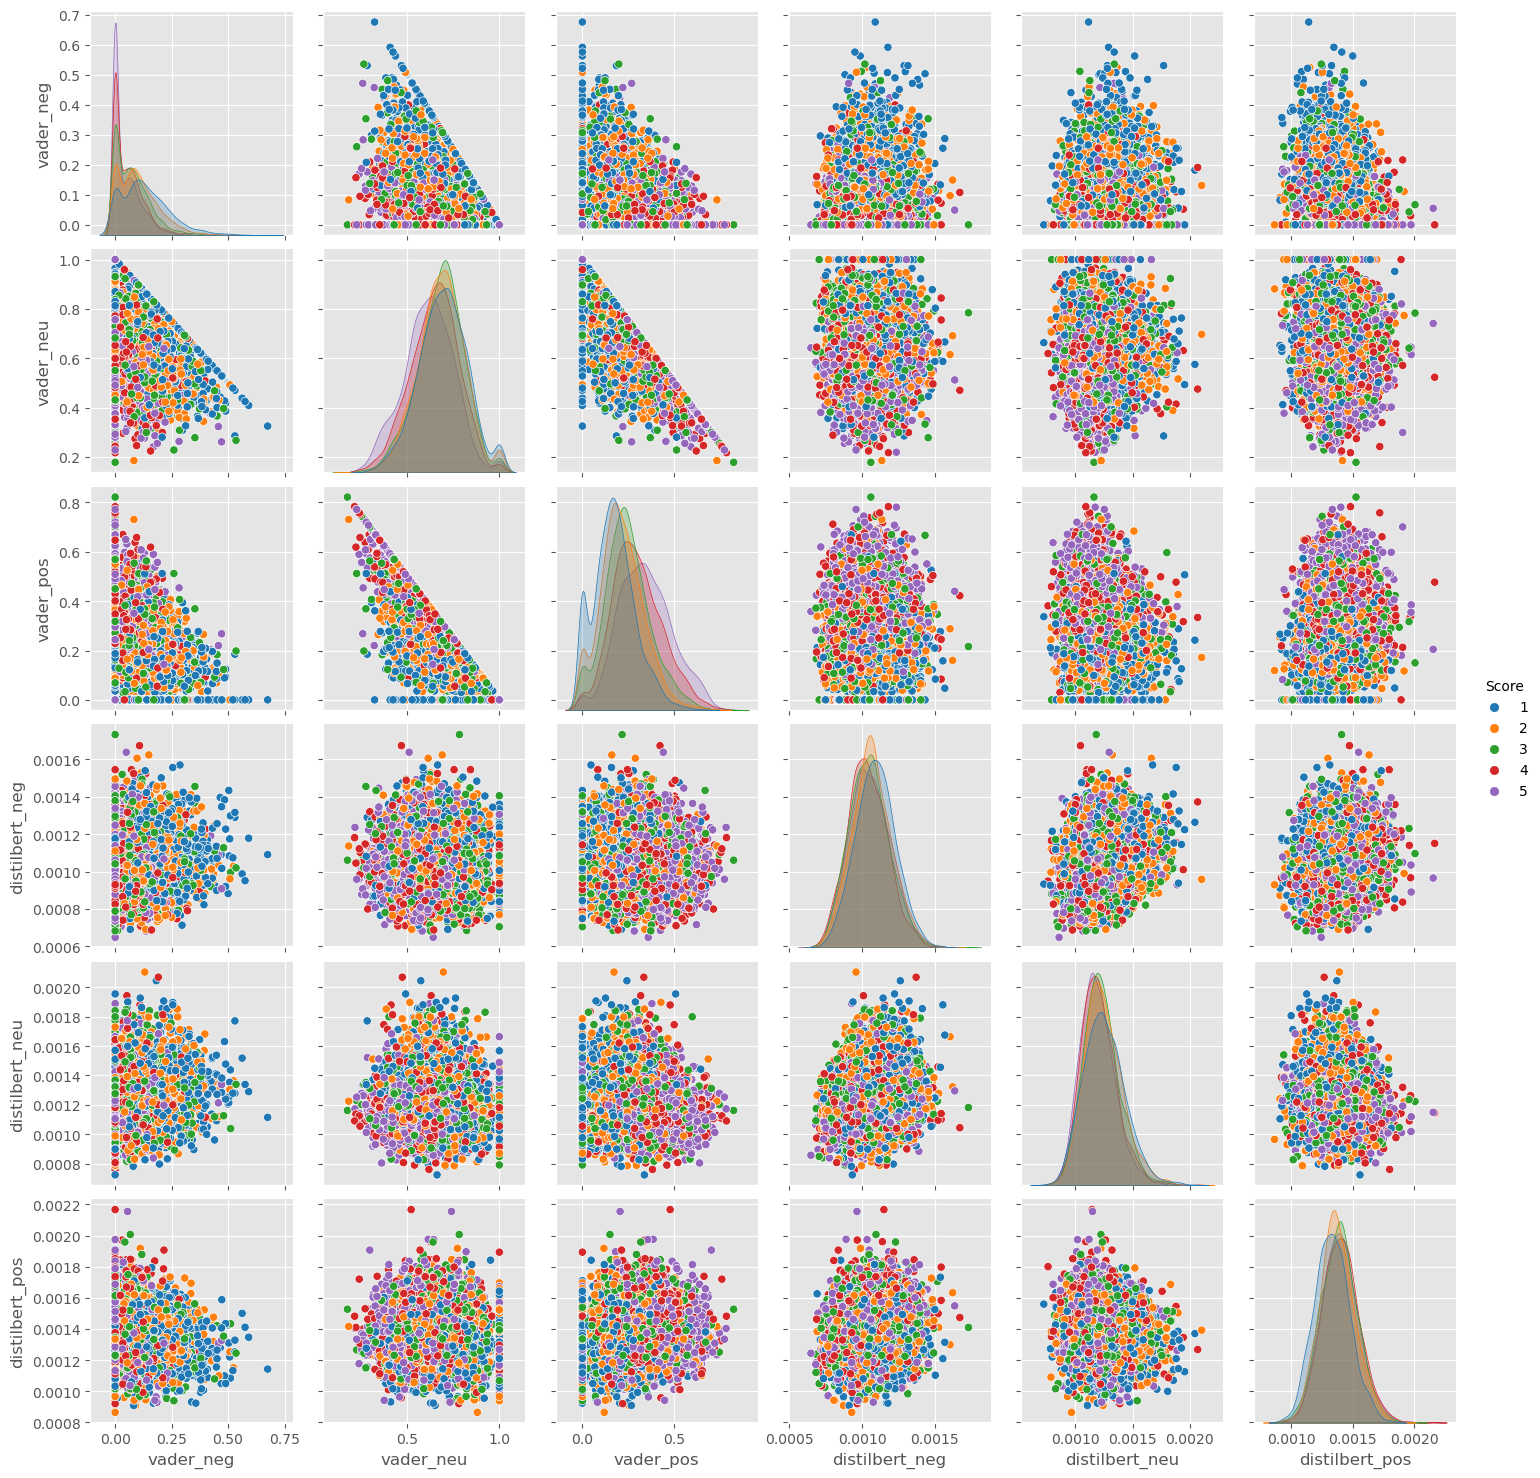

In [74]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos','distilbert_neg', 'distilbert_neu', 'distilbert_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# **Review Examples:**
Positive 1-Star and Negative 5-Star Reviews

In [75]:
results_df

Id  vader_neg  vader_neu  vader_pos  vader_compound  distilbert_neg  \
0     148492      0.092      0.571      0.338          0.9260        0.001174   
1     390216      0.000      0.747      0.253          0.7269        0.001006   
2      31694      0.120      0.748      0.131          0.3489        0.000905   
3      33252      0.050      0.751      0.199          0.8074        0.001108   
4     276055      0.125      0.677      0.198          0.8755        0.001067   
...      ...        ...        ...        ...             ...             ...   
9980  279490      0.054      0.781      0.165          0.7506        0.001034   
9981  119259      0.000      0.756      0.244          0.8539        0.001061   
9982   63581      0.091      0.515      0.394          0.8489        0.000895   
9983  161572      0.063      0.697      0.240          0.8360        0.001257   
9984  333924      0.000      0.431      0.569          0.8979        0.001041   

      distilbert_neu  distilbert_pos   ProductId          UserId  ...  \
0           0.001318        0.001613  B003JA5KLM  A1TITOWKMCRDL2  ...   
1           0.001065        0.001532  B000GZUFKE  A1QGO6SNT6X1VU  ...   
2           0.001598        0.001187  B005GX6G9K  A24V317F6FQOFH  ...   
3           0.001120        0.001228  B001EQ54M8   ARB94UKTX6OVK  ...   
4           0.001324        0.001230  B000FBMFDO  A2MUTRCN4YCJHL  ...   
...              ...             ...         ...             ...  ...   
9980        0.001392        0.001182  B000GZSDPS  A31CXKAMPTZ0KV  ...   
9981        0.001105        0.001462  B001FA1LKC  A2XLHWP7IY2FUV  ...   
9982        0.001115        0.001249  B002IEZJMA   A79372WBA9IJM  ...   
9983        0.001208        0.001414  B000GPM9IK  A2U8MSSBRLOMHL  ...   
9984        0.001276        0.001231  B0032B0BD0   ALL51PH9IIA5X  ...   

     HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                       0                       0      1  1348790400   
1                       0                       0      2  1321660800   
2                       0                       1      1  1348185600   
3                      23                      35      1  1261699200   
4                       0                       0      3  1345248000   
...                   ...                     ...    ...         ...   
9980                    0                       0      2  1348963200   
9981                    0                       0      5  1294012800   
9982                    0                       1      4  1340755200   
9983                    0                       0      3  1350518400   
9984                    0                       0      3  1311552000   

                                                Summary  \
0                                   Weak, boring coffee   
1                                  Neither hot nor sour   
2     If Your Kids are Stupid Enough to Think Water ...   
3                                   only 3/4 pound bags   
4     Mixed feeling, effective but not as easy as pe...   
...                                                 ...   
9980      Lots of soy taste ; far inferior to Wowbutter   
9981                                 Best Earl Grey Tea   
9982            Overall quite tasty for a can of coffee   
9983                          good product, bad product   
9984  Garden of Eatin' Tortilla Chips, Blue, No Salt...   

                                                   Text  \
0     got sample today excited try fail brewing smel...   
1     enjoy spicy food lot bought cup fiestabr turne...   
2     different wat-aah varieties themes picked powe...   
3     starbucks online store coffee 1095lb approx 68...   
4     really dont like everyone makes seem easy use ...   
...                                                 ...   
9980  weve tried several brands soy butter daughter ...   
9981  first discovered ahmad earl grey tea 25 years ...   
9982  illy issimo coffee drink - first smells wonder...

In [76]:
results_df.query('Score == 1') \
    .sort_values('distilbert_pos', ascending=False)['Text'].values[0]

'green tea pale taste tea leaves full grown leaves spring sprout teas price range bebr br initially gave tea 2 stars considering cost tea deserve one star instead'

In [77]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'love vita cocos except one funny taste favorite'

In [78]:
results_df.query('Score == 5') \
    .sort_values('distilbert_neg', ascending=False)['Text'].values[0]

'really love candy bars wispa bars favorite child stopped making us thrilled still able order talk blast past look taste remembered taste great definitely buy future'

In [79]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'tea great husband doesnt like tea loves like'